In [1]:
from typing import List
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
tensor_transform = transforms.ToTensor()
dataset = datasets.MNIST(
    root="../data", train=True, download=True, transform=tensor_transform
)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)


In [3]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 10),
        )
    
        self.sub_decoder_1 = nn.Sequential(
            nn.Linear(5, 10),
            nn.ReLU(),
            nn.Linear(10, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
        )

        self.sub_decoder_2 = nn.Sequential(
            nn.Linear(5, 10),
            nn.ReLU(),
            nn.Linear(10, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        z1 = encoded[:, :5]
        z2 = encoded[:, 5:]
        decoded_1 = self.sub_decoder_1(z1)
        decoded_2 = self.sub_decoder_2(z2)
        decoded_comb = (decoded_1 + decoded_2) / 2
        return decoded_comb, decoded_1, decoded_2, encoded

In [4]:
model = autoencoder()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
epochs = 20
outputs = []
losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Cuda Avalible")
model.to(device)

Cuda Avalible


autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=36, bias=True)
    (5): ReLU()
    (6): Linear(in_features=36, out_features=18, bias=True)
    (7): ReLU()
    (8): Linear(in_features=18, out_features=10, bias=True)
  )
  (sub_decoder_1): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=18, bias=True)
    (3): ReLU()
    (4): Linear(in_features=18, out_features=36, bias=True)
    (5): ReLU()
    (6): Linear(in_features=36, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=784, bias=True)
    (11): Sigmoid()
  )
  (sub_decoder_2): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
   

In [5]:
for epoch in range(epochs):
    for images, _ in loader:
        images = images.view(-1, 28 * 28).to(device)

        reconstructed, first_recon, second_recon ,represent = model(images)
        loss = loss_function(reconstructed, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    outputs.append((epoch, images, reconstructed, first_recon, second_recon, represent))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.6f}")

Epoch 1/20, Loss: 0.042350
Epoch 2/20, Loss: 0.035703
Epoch 3/20, Loss: 0.029207
Epoch 4/20, Loss: 0.029875
Epoch 5/20, Loss: 0.025958
Epoch 6/20, Loss: 0.027475
Epoch 7/20, Loss: 0.027763
Epoch 8/20, Loss: 0.026201
Epoch 9/20, Loss: 0.024063
Epoch 10/20, Loss: 0.025737
Epoch 11/20, Loss: 0.025566
Epoch 12/20, Loss: 0.024426
Epoch 13/20, Loss: 0.026182
Epoch 14/20, Loss: 0.021588
Epoch 15/20, Loss: 0.020937
Epoch 16/20, Loss: 0.021871
Epoch 17/20, Loss: 0.019853
Epoch 18/20, Loss: 0.022502
Epoch 19/20, Loss: 0.020569
Epoch 20/20, Loss: 0.022537


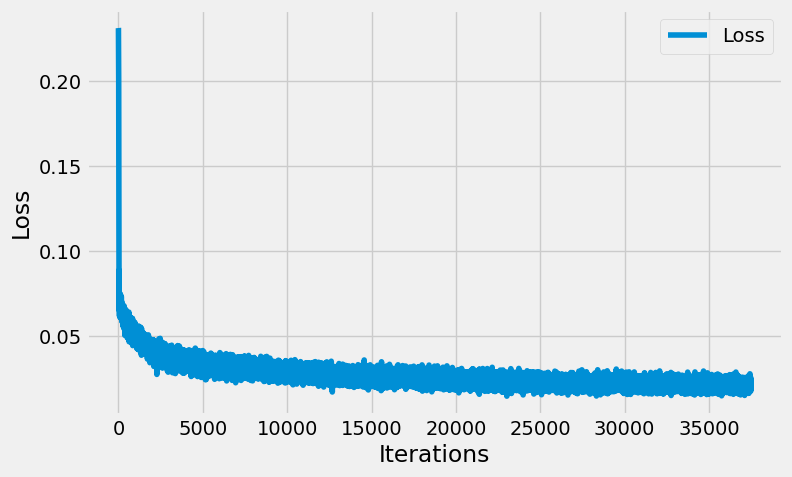

In [8]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

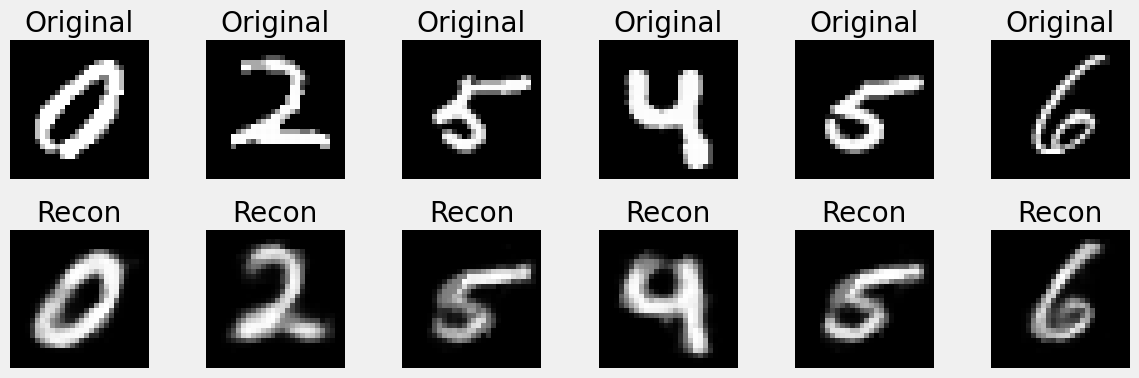

In [7]:
epoch_idx, original_imgs, recon_imgs, first_recon, second_recon, represent = outputs[-1]

n = 6
original_imgs = original_imgs[:n].cpu().view(-1, 28, 28)
recon_imgs = recon_imgs[:n].detach().cpu().view(-1, 28, 28)

plt.figure(figsize=(12, 4))
for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(original_imgs[i], cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2, n, n + i + 1)
    plt.imshow(recon_imgs[i], cmap='gray')
    plt.title("Recon")
    plt.axis('off')

plt.tight_layout()
plt.show()

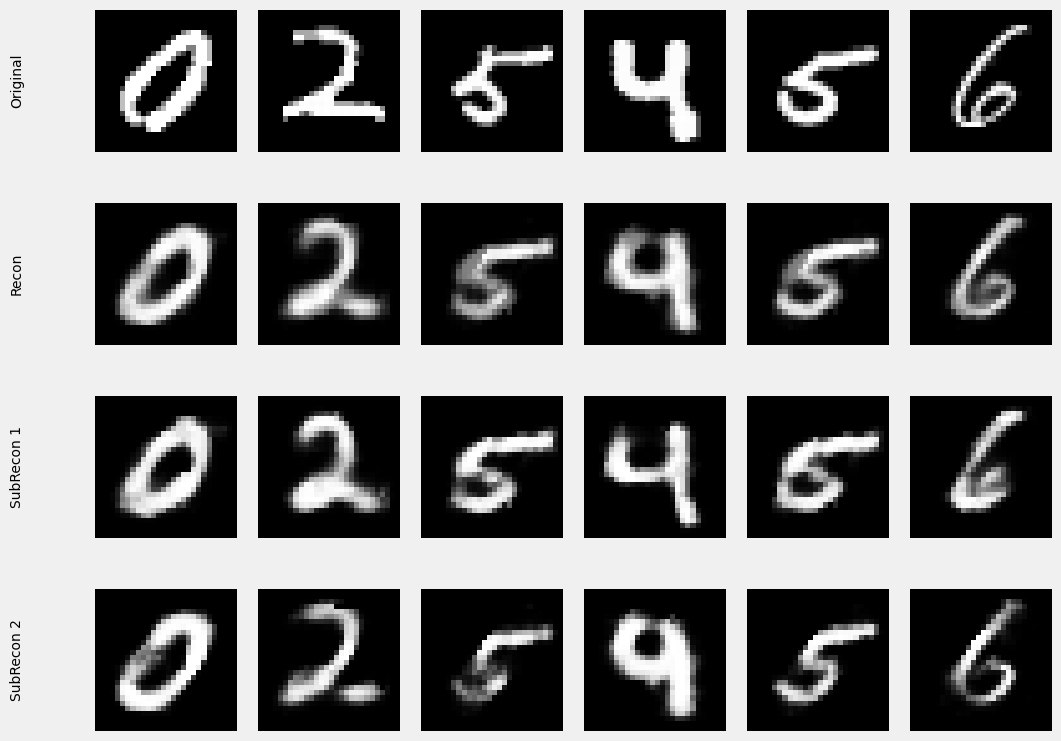

In [11]:
epoch_idx, original_imgs, recon_imgs, first_recon, second_recon, represent = outputs[-1]
n = min(6, original_imgs.size(0))  # Visualize up to 6 samples

# Ensure all tensors are on CPU and detached from computation graph
original_imgs = original_imgs[:n].detach().cpu().view(-1, 28, 28)
recon_imgs = recon_imgs[:n].detach().cpu().view(-1, 28, 28)
first_recon = first_recon[:n].detach().cpu().view(-1, 28, 28)
second_recon = second_recon[:n].detach().cpu().view(-1, 28, 28)
represent = represent[:n].detach().cpu()  # shape: [n, latent_dim]

# Stack for convenient iteration
image_sets = [
    ("Original", original_imgs),
    ("Recon", recon_imgs),
    ("SubRecon 1", first_recon),
    ("SubRecon 2", second_recon)
]


rows = len(image_sets)
plt.figure(figsize=(1.8 * n, 2 * rows))

for row, (title, img_batch) in enumerate(image_sets):
    for col in range(n):
        ax = plt.subplot(rows, n, row * n + col + 1)
        ax.imshow(img_batch[col], cmap='gray')
        ax.axis('off')
        
        # Add row labels only on the first column
        if col == 0:
            ax.text(-0.5, 0.5, title, fontsize=10, va='center', ha='right', transform=ax.transAxes, rotation=90)

plt.tight_layout()
plt.show()


In [8]:
torch.save(model.state_dict(), "../output/autoencoder_sub_weights.pth")
torch.save(model, "../output/autoencoder_sub_weights.pth")
print("Saved")

Saved
